In [43]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import shap
import pacmap
import matplotlib.pyplot as plt


In [2]:
# Load the data, Brute Force SSH/FTP from CSE-CIC-IDS2018 (https://www.unb.ca/cic/datasets/ids-2018.html)
df = pd.read_csv('02-14-2018.csv')

# Only include a subset of the columns
columns_to_include = ['Flow Duration', 'Tot Fwd Pkts', 'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Label']
df = df[columns_to_include]


# Separate numeric and non-numeric columns
df_numeric = df.select_dtypes(include=[np.number])
df_non_numeric = df.select_dtypes(exclude=[np.number])

# Force extreme values
def normalize_column_sigmoid(column):
    return 1 / (1 + np.exp(-column))

# Apply the normalization function to each numeric column
df_normalized_numeric = df_numeric.apply(normalize_column_sigmoid)

# Concatenate the non-numeric columns with the normalized numeric columns
df_final = pd.concat([df_normalized_numeric, df_non_numeric], axis=1)

# Optionally, re-order the columns to match the original DataFrame's order
df_final = df_final[df.columns]



df_final

overflow encountered in exp


,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Label
0,1.0,0.952574,0.500000,0.5,0.5,Benign
1,1.0,0.952574,0.500000,0.5,0.5,Benign
2,1.0,0.952574,0.500000,0.5,0.5,Benign
3,1.0,1.000000,0.999955,1.0,1.0,Benign
4,1.0,0.999999,0.999983,1.0,1.0,Benign
...,...,...,...,...,...,...
1048570,1.0,0.993307,0.993307,1.0,1.0,Benign
1048571,1.0,0.880797,0.500000,0.5,0.5,Benign
1048572,1.0,0.952574,0.731059,0.5,0.5,Benign
1048573,1.0,0.952574,0.731059,0.5,0.5,Benign


In [3]:
df = df_final
label_counts = df['Label'].value_counts()
print(label_counts)

df['Label'] = np.where(df['Label'] == 'Benign', 'Benign', 'Malicious')
label_counts = df['Label'].value_counts()
print(label_counts)


Label
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: count, dtype: int64
Label
Benign       667626
Malicious    380949
Name: count, dtype: int64


In [4]:
label_encoder = LabelEncoder()
df['Label'] = label_encoder.fit_transform(df['Label'])
n_classes = len(label_encoder.classes_)

# Split the data
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Define a dataset class
class DataFrameDataset(Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe['Label'].values
        self.features = dataframe.drop('Label', axis=1).values.astype(np.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Create datasets
train_dataset = DataFrameDataset(train_df)
test_dataset = DataFrameDataset(test_df)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=1028, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1028, shuffle=True)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Basic binary classifier
class SimpleNN(nn.Module):
    def __init__(self, input_size, dropout_rate=0.5):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(50, 100)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(100, 1)  # Output layer for binary classification

    def forward(self, x):
        x = self.viz(x)
        x = self.dropout2(x)
        x = self.fc3(x) 
        return x
    
    # Latent layer for visualization
    def viz(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        return x

# Initialize the model
input_size = train_df.shape[1] - 1  # assuming 'train_df' is already defined
num_classes = len(label_encoder.classes_)  # assuming 'label_encoder' is already defined
model = SimpleNN(input_size=input_size).to(device)

In [7]:
criterion = nn.BCEWithLogitsLoss()  # Binary cross entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
def train_model(model, train_loader, epochs):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device).float()  # Ensure labels are float for BCEWithLogitsLoss
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs.view(-1), labels)  # Flatten outputs to match label shape
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}')


In [9]:
train_accuracies = []
val_accuracies = []

In [ ]:
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device).float()
            outputs = model(data)
            predicted = (torch.sigmoid(outputs.view(-1)) > 0.5).float()  # Using 0.5 as threshold for binary classification
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

def train_model(model, train_loader, validation_loader, epochs, clip_value=1.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for data, labels in train_loader:
            data, labels = data.to(device), labels.to(device).float()
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            total_loss += loss.item()
        
        train_loss = total_loss / len(train_loader)
        validation_accuracy = evaluate_model(model, validation_loader)
        train_accuracy = evaluate_model(model, train_loader)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(validation_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy (Train/Val): {train_accuracy:.2f}%/{validation_accuracy:.2f}%')

train_accuracies.append(evaluate_model(model, train_loader))
val_accuracies.append(evaluate_model(model, test_loader))
print(f"Start accuracy (Train/Val): {train_accuracies[0]:0.2f}%/{val_accuracies[0]:0.2f}%")
train_model(model, train_loader, test_loader, epochs=5)

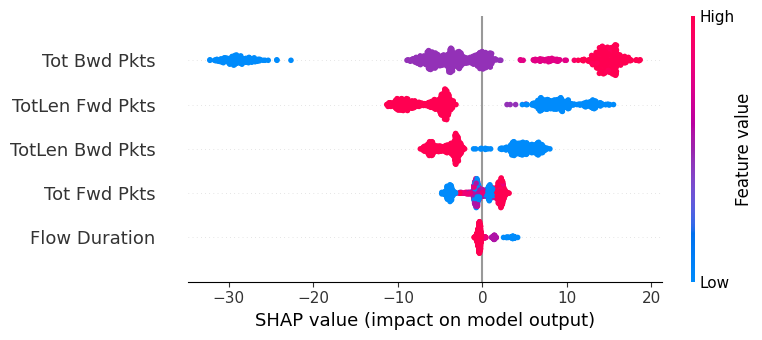

In [34]:
model.eval()

data_for_explanation = next(iter(test_loader))
features, y = data_for_explanation
explainer = shap.GradientExplainer(model.to('cpu'), features)
shap_values = explainer.shap_values(features)
shap.summary_plot(shap_values, features, feature_names=list(columns_to_include), show=False)
plt.savefig('shap_beeswarm_plot.png', bbox_inches='tight')
plt.show()
plt.close()

In [35]:
exp = explainer(features)[1]
exp.base_values = 0.5
exp.feature_names = list(columns_to_include)

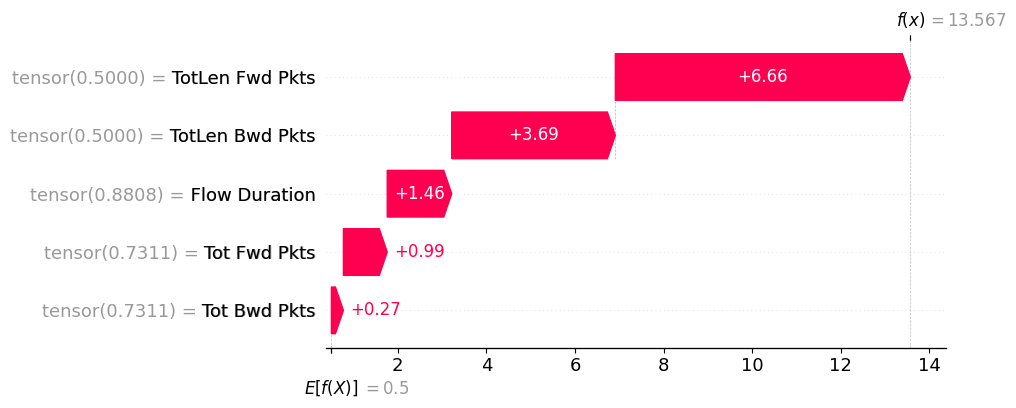

In [36]:
shap.waterfall_plot(exp, max_display=25)

[]

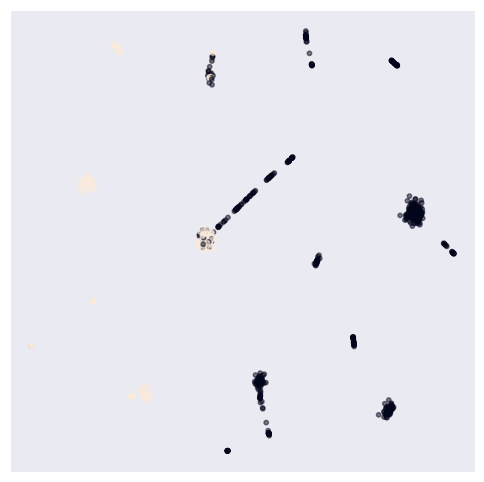

In [48]:
X = model.viz(features).detach().numpy()
embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
X_transformed = embedding.fit_transform(X, init="pca")
# visualize the embedding
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(X_transformed[:, 0], X_transformed[:, 1],  c=y, s=10, alpha=0.5)
ax.set_xticks([])
ax.set_yticks([])

In [ ]:
plt.plot(train_accuracies, label='Training Accuracy', zorder=1)
plt.scatter( range(len(val_accuracies)), val_accuracies, 
             s=50, alpha=0.5, c='orange', zorder=2)
plt.plot(val_accuracies, label='Validation Accuracy', c='orange', linestyle='dashed', alpha=0.25)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.savefig('training.png', bbox_inches='tight') 

plt.show()
plt.close()